In [86]:
import netCDF4 as nc
import xarray as xr
import numpy as np
import datetime
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression

In [31]:
#download
!curl https://zenodo.org/record/6532501/files/CESM_EA_SPI.nc?download=1 --output CESM_EA_SPI.nc

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 44.0M  100 44.0M    0     0  3895k      0  0:00:11  0:00:11 --:--:-- 7958k


## Data visualization

In [22]:
file_name = 'CESM_EA_SPI.nc'
ds = xr.open_dataset(file_name)
spi = ds['spi']
spi

<xarray.DataArray 'spi' (time: 21612, lat: 13, lon: 20)>
[5619120 values with dtype=float64]
Coordinates:
  * time     (time) object '0400-01-16T12:00:00' ... '2200-12-16T12:00:00'
  * lat      (lat) float64 3.298 4.241 5.183 6.126 ... 11.78 12.72 13.66 14.61
  * lon      (lon) float64 23.75 25.0 26.25 27.5 28.75 ... 43.75 45.0 46.25 47.5
Attributes:
    title:          Standardized Precipitation Index
    standard_name:  atmosphere_water__standardized_precipitation_wetness_index
    long_name:      Standardized Precipitation Index
    units:          unitless
    valid_min:      -3.09
    valid_max:      3.09
    valid_range:    [-3.09  3.09]

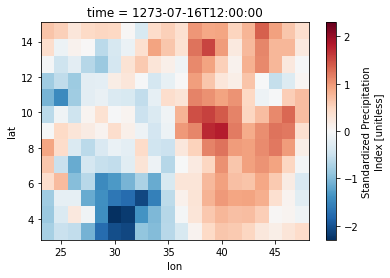

In [6]:
#plot spatial spi distribution for random time
time = np.random.randint(spi.shape[0])
spi2d = spi.isel(time=time)
spi2d.plot()

Text(0, 0.5, 'SPI')

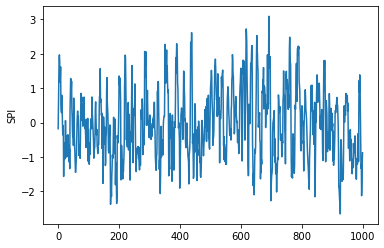

In [28]:
#plot spi time series at random location
lat = np.random.randint(spi.shape[1])
lon = np.random.randint(spi.shape[2])
k = np.random.randint(spi.shape[0]-1000)
plt.plot(spi[k:k+1000,lat,lon])
plt.ylabel('SPI')

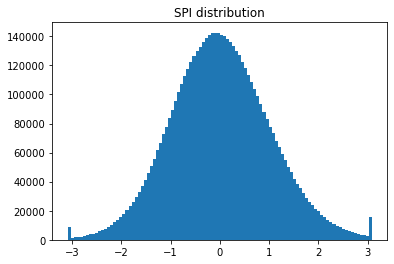

In [29]:
#plot overall spi distribution
plt.hist(np.array(spi).flatten(), bins=100)
plt.title('SPI distribution')
plt.show()

## Prepare data

In [132]:
def assemble_predictors_predictands(start_date, end_date, lead_time, dataset, num_input_time_steps):
    '''
    Args
    ----
    start_date (str): The start date for extraction. Important, put the trailing 0 at the beginning of year for dates before 1000 (e.g., '0400')
    end_date (str): The end date for extraction
    lead_time (int): The number of months between the predictor/predictand
    dataset (str): Either 'CESM' or 'ECMWF'
    num_input_time_steps (int): The number of time steps to use for each predictor samples
    '''    
    file_name = {'CESM': 'CESM_EA_SPI.nc', 'ECMWF': 'ECMWF_EA_SPI.nc'}[dataset]
    ds = xr.open_dataset(file_name)
    spi = ds['spi'].sel(time=slice(start_date,end_date))
    num_samples=spi.shape[0]
    #Stack and remove nans
    spi = np.stack([spi.values[n-num_input_time_steps:n] for n in range(num_input_time_steps, num_samples+1)])
    num_samples = spi.shape[0]
    spi[np.isnan(spi)] = 0
    #make sure we have floats in there
    X = spi.astype(np.float32)
    # select Y
    if dataset == 'ECMWF':
        start_date_plus_lead = pd.to_datetime(start_date) + pd.DateOffset(months=lead_time+num_input_time_steps-1)
        end_date_plus_lead = pd.to_datetime(end_date) + pd.DateOffset(months=lead_time)
    elif dataset == 'CESM':
        t_start=datetime.datetime(int(start_date.split('-')[0]),int(start_date.split('-')[1]),int(start_date.split('-')[2]))
        t_end=datetime.datetime(int(end_date.split('-')[0]),int(end_date.split('-')[1]),int(end_date.split('-')[2]))
        start_date_plus_lead = t_start + relativedelta(months=lead_time+num_input_time_steps-1)
        end_date_plus_lead = t_end + relativedelta(months=lead_time)
        if len(str(start_date_plus_lead.year))<4:
            start_date_plus_lead = '0'+start_date_plus_lead.strftime('%Y-%m-%d')
        elif len(str(start_date_plus_lead.year))==4:
            start_date_plus_lead = start_date_plus_lead.strftime('%Y-%m-%d')
        if len(str(end_date_plus_lead.year))<4:
            end_date_plus_lead = '0'+end_date_plus_lead.strftime('%Y-%m-%d')
        elif len(str(end_date_plus_lead.year))==4:
            end_date_plus_lead = end_date_plus_lead.strftime('%Y-%m-%d')
    subsetted_ds = ds['spi'].sel(time=slice(start_date_plus_lead, end_date_plus_lead))
    y = subsetted_ds.values.astype(np.float32)
    y[np.isnan(y)] = 0
    ds.close()
    X = np.moveaxis(X, 1,3)
    orig_shape_X = X.shape
    orig_shape_y = y.shape
    y = y.reshape(np.shape(y)[0]*np.shape(y)[1]*np.shape(y)[2])
    
    X = X.reshape(np.shape(X)[0]*np.shape(X)[1]*np.shape(X)[2], np.shape(X)[3])
    return X,y, orig_shape_X, orig_shape_y


In [133]:
num_input_time_steps = 3 
lead_time = 2

climate_model = 'CESM'
train_start_date = '0400-01-01'
train_end_date = '1800-12-31'

test_start_date = '1801-01-01'
test_end_date = '1978-12-31'

In [134]:
train_predictors, train_predictands, orig_shape_Xtrain, orig_shape_ytrain = assemble_predictors_predictands(train_start_date, train_end_date, lead_time, climate_model, num_input_time_steps)
test_predictors, test_predictands, orig_shape_Xtest, orig_shape_ytest = assemble_predictors_predictands(test_start_date, test_end_date, lead_time, climate_model,num_input_time_steps)
print(train_predictors.shape, train_predictands.shape)


(4370600, 3) (4370600,)


## Train model

In [135]:
#regr = RandomForestRegressor(max_depth=4, n_jobs=-1, max_samples=0.1)
regr = LinearRegression()
regr.fit(train_predictors, train_predictands)


LinearRegression()

## Predict

In [136]:
pred = regr.predict(test_predictors)

## Evaluate model

In [137]:
mse = mean_squared_error(pred, test_predictands)
print('MSE:', mse)

MSE: 0.5489132


In [138]:
#reshape prediction to initial shape
pred = pred.reshape(orig_shape_ytest)
test_predictands = test_predictands.reshape(orig_shape_ytest)

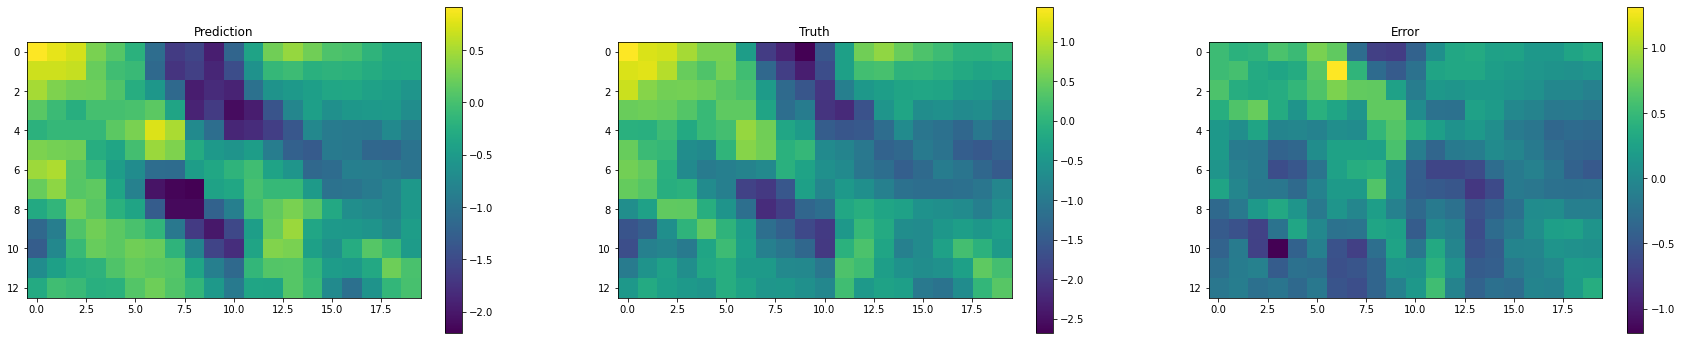

In [139]:
time = np.random.randint(pred.shape[0])
plt.figure(figsize=(30,6))
plt.subplot(1,3,1)
plt.title('Prediction')
plt.imshow(pred[time,:,:])
plt.colorbar()
plt.subplot(1,3,2)
plt.title('Truth')
plt.imshow(test_predictands[time,:,:])
plt.colorbar()
plt.subplot(1,3,3)
plt.title('Error')
plt.imshow(test_predictands[time,:,:]-pred[time,:,:])
plt.colorbar()


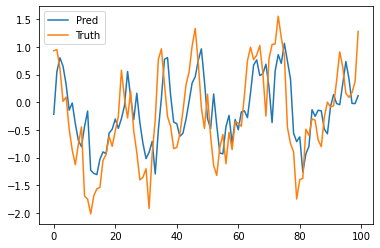

In [140]:
#plot spi time series at random location
lat = np.random.randint(pred.shape[1])
lon = np.random.randint(pred.shape[2])
k = np.random.randint(pred.shape[0]-100)
plt.plot(pred[k:k+100,lat,lon], label='Pred')
plt.plot(test_predictands[k:k+100,lat,lon], label='Truth')
plt.legend()
